In [1]:
import pandas as pd
pd.set_option('max.columns',None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import xgboost as xgb
import lightgbm as lgb

from sklearn.model_selection import StratifiedKFold, KFold
import time
from sklearn import metrics

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,precision_recall_fscore_support,roc_curve,auc,roc_auc_score,precision_score,recall_score

In [2]:
train_set = pd.read_csv('A榜给选手数据/train_set.csv')
train_label = pd.read_csv('A榜给选手数据/train_label.csv')
result_predict_B = pd.read_csv('B榜给选手数据/result_predict_B.csv')
result_predict_A = pd.read_csv('A榜给选手数据/result_predict_A.csv')

train_set = train_set.merge(train_label,how='left',on='user_id')
data = pd.concat([train_set,result_predict_B],axis=0,ignore_index=True)

In [3]:
data['X26'].fillna(-1,inplace=True)
data['X27'].fillna(0,inplace=True)
data['X38'].fillna(0,inplace=True)

col_idx = data['X26'].value_counts()
for idx in col_idx[col_idx < 10].index:
    data['X26'] = data['X26'].replace(idx, -1)
    data['X26'] = data['X26'].replace(idx, -1) 
    
for col in ['X1', 'X5']:
    data[col] = pd.factorize(data[col])[0]

In [4]:
data['arpu_incre_1'] = data['X6'] - data['X7']
data['arpu_incre_2'] = data['X6'] - data['X8']
data['arpu_incre_3'] = data['X7'] - data['X8']
data['arpu_rate_1'] = (data['X6'] - data['X7']) / (data['X7'] + 1)
data['arpu_rate_2'] = (data['X6'] - data['X8']) / (data['X8'] + 1)
data['arpu_rate_3'] = (data['X7'] - data['X8']) / (data['X8'] + 1)

data['dou_incre_1'] = data['X9'] - data['X10']

data['mou_incre_1'] = data['X12'] - data['X13']

data['dangyue_arpu'] = data['X6'] / data['X15']
data['dangyue_dou'] = data['X9'] / data['X16']
data['dangyue_mou'] = data['X12'] / data['X17']
data['mou_dou_1'] = data['X17'] / data['X16']
data['taocan_arpu_1'] = data['X32'] / data['X15']
data['taocan_arpu_2'] = data['X33'] / data['X15']

data['yuyin_mean'] = (data['X18'] + data['X19'] + data['X20']) / 3
data['liuliang_mean'] = (data['X21'] + data['X22'] + data['X23']) / 3

data['yuyin_incre_1'] = data['X18'] - data['X19']

data['liuliang_incre_1'] = data['X21'] - data['X22']

data['baohe_mean'] = (data['X34'] + data['X35'] + data['X36']) / 3
data['baohe_incre_1'] = data['X34'] - data['X35']

data['dangyue_yuyin'] = data['X18'] / data['yuyin_mean']
data['liuliang_yuyin'] = data['X21'] / data['liuliang_mean']
data['dangyue_baohe'] = data['X34'] / data['baohe_mean']

data['arpu_qushi'] = (data['X6'] - data['X8']) / data['X15']
data['dou_qushi'] = (data['X9'] - data['X11']) / data['X16']
data['mou_qushi'] = (data['X12'] - data['X14']) / data['X17']
data['yuyin_qushi'] = (data['X20'] - data['X18']) / data['yuyin_mean']
data['liuliang_qushi'] = (data['X23'] - data['X21']) / data['liuliang_mean']
data['baohe_qushi'] = (data['X36'] - data['X34']) / data['baohe_mean']

data['X38_flag'] = data['X38'].apply(lambda x: 1 if x>0 else 0)
data['5G_num'] = data[['X38', 'X41', 'X42','X43']].sum(1)

bins = [0,8,18,38,58,88,128,168,238,max(data['X33'])]
data['X33_bin'] = pd.cut(data['X33'], bins,right=True,labels=False)     

In [5]:
cate_cols = ['X3','X5', 'X26','X33_bin']
num_cols = ['X4', 'X15','X16', 'X17','X32','X33','X38','yuyin_mean','liuliang_mean','baohe_mean']

from tqdm import tqdm
for f in tqdm(cate_cols):
    data[f + '_count'] = data[f].map(data[f].value_counts())
    
# 偏离值特征            
for col in cate_cols:
    for feature in num_cols:
        tmp = data.groupby(col)[feature].agg([sum, min, max, np.mean,np.std]).reset_index()
        tmp = pd.merge(data, tmp, on=col, how='left')
        data['{}-mean_gb_{}'.format(feature, col)] = data[feature] - tmp['mean']
        data['{}-min_gb_{}'.format(feature, col)] = data[feature] - tmp['min']
        data['{}-max_gb_{}'.format(feature, col)] = data[feature] - tmp['max']
        data['{}/sum_gb_{}'.format(feature, col)] = data[feature] / tmp['sum']

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 29.71it/s]


In [6]:
data.drop(['X33_bin'],axis=1,inplace=True)

data = data.replace(-np.inf, np.nan)
data = data.replace(np.inf, np.nan)

train_data = data[data.label.notna()].copy()
test_data = data[data.label.isna()].copy()
y_train = train_data['label'].copy()

In [7]:
feature_importance_lgb = pd.read_csv('feature_importance_lgb.csv')
lgb_select_feats = feature_importance_lgb[['feature', 'importance']].groupby('feature').mean().sort_values(by='importance', ascending=False)[:200]
select_feats_lgb = lgb_select_feats.index.tolist()

features = [f for f in select_feats_lgb]
cat_features = ['X1', 'X25','X29','X31', 'X37', 'X39', 'X41', 'X42', 'X43']
X = train_data[features].copy()
X_test = test_data[features].copy()
y = train_data['label'].copy()

In [8]:
def train_model_classification(X, X_test, y, params, num_classes=2,
                               folds=None, model_type='lgb',
                               eval_metric='logloss', columns=None,
                               plot_feature_importance=False,
                               cat_features=[],
                               model=None, verbose=10000,
                               early_stopping_rounds=200,
                               splits=None, n_folds=3):

    start_time = time.time()
    global y_pred_valid, y_pred

    columns = X.columns if columns is None else columns
    X_test = X_test[columns]
    splits = folds.split(X, y) if splits is None else splits
    n_splits = folds.n_splits if splits is None else n_folds

    # to set up scoring parameters
    metrics_dict = {
        'logloss': {
            'lgb_metric_name': 'logloss',
            'xgb_metric_name': 'logloss',
            'catboost_metric_name': 'Logloss',
            'sklearn_scoring_function': metrics.log_loss
        },
        'lb_score_method': {
            'sklearn_scoring_f1': metrics.f1_score,  
            'sklearn_scoring_accuracy': metrics.accuracy_score, 
            'sklearn_scoring_auc': metrics.roc_auc_score
        },
    }
    result_dict = {}

    # out-of-fold predictions on train data
    oof = np.zeros(shape=(len(X), num_classes))
    # averaged predictions on train data
    prediction = np.zeros(shape=(len(X_test), num_classes))
    # list of scores on folds
    acc_scores=[]
    scores = []
    f1_scores = []
    precision_scores = []
    recall_scores = []
    # feature importance
    feature_importance = pd.DataFrame()

    # split and train on folds
    for fold_n, (train_index, valid_index) in enumerate(splits):
        if verbose:
            print(f'Fold {fold_n + 1} started at {time.ctime()}')
        if type(X) == np.ndarray:
            X_train, X_valid = X[train_index], X[valid_index]
            y_train, y_valid = y[train_index], y[valid_index]
        else:
            X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

        if model_type == 'lgb':
            model = lgb.LGBMClassifier(**params)
            model.fit(X_train, y_train,
                      eval_set=[(X_train, y_train), (X_valid, y_valid)],
                      categorical_feature = cat_features,
                      eval_metric=metrics_dict[eval_metric]['lgb_metric_name'],
                      verbose=verbose,
                      early_stopping_rounds=early_stopping_rounds)

            y_pred_valid = model.predict_proba(X_valid)
            y_pred = model.predict_proba(X_test, num_iteration=model.best_iteration_)

        if model_type == 'xgb':
            model = xgb.XGBClassifier(**params)
            model.fit(X_train, y_train,
                      eval_set=[(X_train, y_train), (X_valid, y_valid)],
                      eval_metric=metrics_dict[eval_metric]['xgb_metric_name'],
                      verbose=bool(verbose),  # xgb verbose bool
                      early_stopping_rounds=early_stopping_rounds)
            y_pred_valid = model.predict_proba(X_valid)
            y_pred = model.predict_proba(X_test, ntree_limit=model.best_ntree_limit)
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            y_pred_valid = model.predict_proba(X_valid)
            score = metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid)
            print(f'Fold {fold_n}. {eval_metric}: {score:.4f}.')
            y_pred = model.predict_proba(X_test)

        if model_type == 'cat':
            model = CatBoostClassifier(iterations=20000, eval_metric=metrics_dict[eval_metric]['catboost_metric_name'],
                                       **params,
                                       loss_function=metrics_dict[eval_metric]['catboost_metric_name'])
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True,
                      verbose=False)

            y_pred_valid = model.predict_proba(X_valid)
            y_pred = model.predict_proba(X_test)

        oof[valid_index] = y_pred_valid
        # 评价指标
        acc_scores.append(
            metrics_dict['lb_score_method']['sklearn_scoring_accuracy'](y_valid, np.argmax(y_pred_valid, axis=1)))
        scores.append(
            metrics_dict['lb_score_method']['sklearn_scoring_auc'](y_valid, y_pred_valid[:,1]))
        f1_scores.append(f1_score(y_valid, [1 if i >= 0.3 else 0 for i in y_pred_valid[:,1]]))
        precision_scores.append(precision_score(y_valid, [1 if i >= 0.3 else 0 for i in y_pred_valid[:,1]]))
        recall_scores.append(recall_score(y_valid, [1 if i >= 0.3 else 0 for i in y_pred_valid[:,1]]))
        print(acc_scores)
        print(scores)
        print(f1_scores)
        print(precision_scores)
        print(recall_scores)
        prediction += y_pred

        if model_type == 'lgb' and plot_feature_importance:
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

        if model_type == 'xgb' and plot_feature_importance:
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    prediction /= n_splits
    print('CV mean auc_score: {0:.8f}, std: {1:.8f}.'.format(np.mean(scores), np.std(scores)))
    print('CV mean acc_score: {0:.8f}, std: {1:.8f}.'.format(np.mean(acc_scores), np.std(acc_scores)))
    print('CV mean f1_score: {0:.8f}, std: {1:.8f}.'.format(np.mean(f1_scores), np.std(f1_scores)))
    print('CV mean precision_score: {0:.8f}, std: {1:.8f}.'.format(np.mean(precision_scores), np.std(precision_scores)))
    print('CV mean recall_score: {0:.8f}, std: {1:.8f}.'.format(np.mean(recall_scores), np.std(recall_scores)))

    result_dict['oof'] = oof
    result_dict['prediction'] = prediction
    result_dict['acc_scores'] = acc_scores
    result_dict['scores'] = scores
    result_dict['f1_scores'] =  f1_scores
    result_dict['precision_scores'] =  precision_scores
    result_dict['recall_scores'] =  recall_scores


    if model_type == 'lgb' or model_type == 'xgb':
        if plot_feature_importance:
            feature_importance["importance"] /= n_splits
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12))
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
            plt.title('LGB Features (avg over folds)')
            plt.show()
            result_dict['feature_importance'] = feature_importance
    end_time = time.time()

    print("train_model_classification cost time:{}".format(end_time - start_time))
    return result_dict

分类个数num_classes:2
Fold 1 started at Fri Mar 26 21:31:00 2021
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Training until validation scores don't improve for 200 rounds
[200]	training's binary_logloss: 0.30274	training's auc: 0.907478	valid_1's binary_logloss: 0.304568	valid_1's auc: 0.906172
[400]	training's binary_logloss: 0.28419	training's auc: 0.914232	valid_1's binary_logloss: 0.289647	valid_1's auc: 0.910027
[600]	training's binary_logloss: 0.276638	training's auc: 0.918831	valid_1's binary_logloss: 0.286436	valid_1's auc: 0.911536
[800]	training's binary_logloss: 0.271093	training's auc: 0.922463	valid_1's binary_logloss: 0.285143	valid_1's auc: 0.912167
[1000]	training's binary_logloss: 0.266123	training's auc: 0.925778	valid_1's binary_logloss: 0.284341	valid_1's auc: 0.912547
[1200]	training's binary_logloss: 0.261755	training's auc: 0.928701	valid_1's binary_logloss: 0.284108	valid_1's auc: 

[1000]	training's binary_logloss: 0.264794	training's auc: 0.926769	valid_1's binary_logloss: 0.290355	valid_1's auc: 0.906949
[1200]	training's binary_logloss: 0.260485	training's auc: 0.929668	valid_1's binary_logloss: 0.289985	valid_1's auc: 0.907185
[1400]	training's binary_logloss: 0.256369	training's auc: 0.932461	valid_1's binary_logloss: 0.289835	valid_1's auc: 0.907274
[1600]	training's binary_logloss: 0.252639	training's auc: 0.934872	valid_1's binary_logloss: 0.289697	valid_1's auc: 0.907358
[1800]	training's binary_logloss: 0.248882	training's auc: 0.937461	valid_1's binary_logloss: 0.289733	valid_1's auc: 0.907349
Early stopping, best iteration is:
[1607]	training's binary_logloss: 0.252493	training's auc: 0.934972	valid_1's binary_logloss: 0.28969	valid_1's auc: 0.907363
[0.8815, 0.8821428571428571, 0.88275, 0.8818928571428571, 0.8823571428571428]
[0.9127246731505102, 0.9119684869260204, 0.9139724569515307, 0.9104774075255103, 0.9073625717474488]
[0.7020321553905167, 0.70

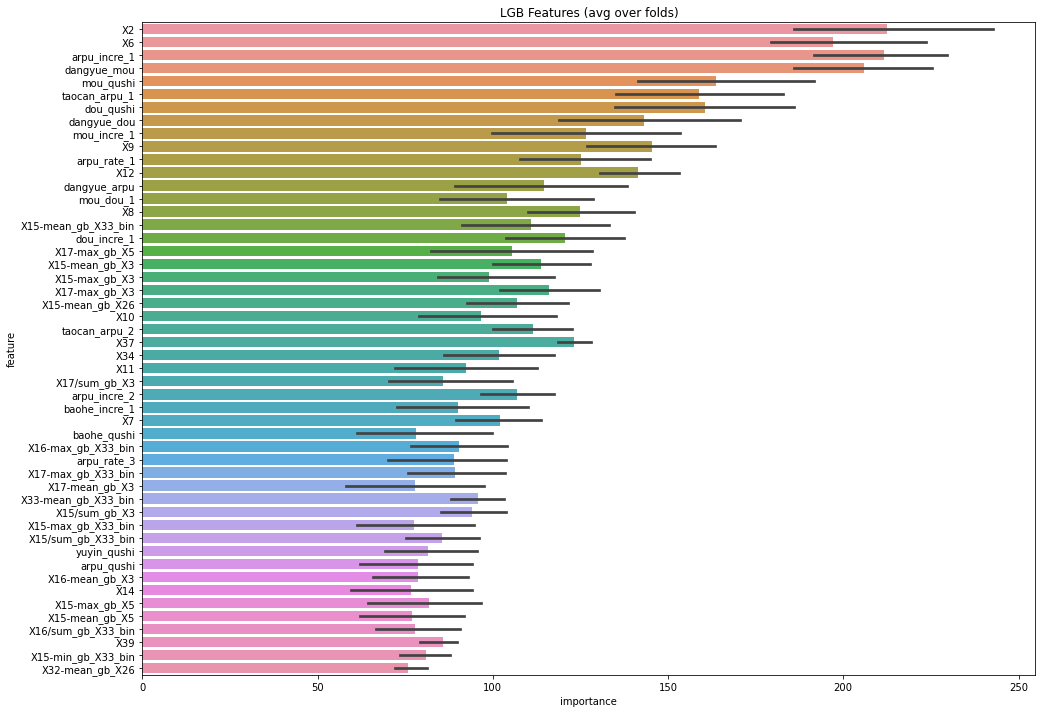

train_model_classification cost time:2001.6229503154755
0.9113011192602041


In [9]:
lgb_params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'n_estimators': 100000,
    'learning_rate': 0.01,
    'subsample_freq': 8,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'feature_fraction_seed': 11,
    'max_depth': 7,
    'reg_alpha': 0.5,
    'reg_lambda': 1,
    'n_jobs': -1,
    'metric': 'auc',
}

n_fold = 5
num_classes = 2
print("分类个数num_classes:{}".format(num_classes))
folds = StratifiedKFold(n_splits=n_fold, random_state=2021)

result_dict_lgb = train_model_classification(X=X,
                                             X_test=X_test,
                                             y=y,
                                             params=lgb_params,
                                             num_classes=num_classes,
                                             folds=folds,
                                             model_type='lgb',
                                             eval_metric='logloss',
                                             plot_feature_importance=True,
                                             cat_features=cat_features,
                                             verbose=200,
                                             early_stopping_rounds=200,
                                             n_folds=n_fold
                                             )

acc_score = np.mean(result_dict_lgb['acc_scores'])
score = np.mean(result_dict_lgb['scores'])
print(score)

In [14]:
sub_df = test_data[['user_id']].copy()
sub_df['oof_lgb'] = result_dict_lgb['prediction'][:, 1]
sub_df.to_csv('oof_lgb_1.csv', index=False)